<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/tim-updates/tim-lr-pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

import joblib
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
repo_path = '/content/drive/MyDrive/milestone-ii/'
train_path = ''.join([repo_path, 'Training_set.csv'])
test_path = ''.join([repo_path, 'Testing_set.csv'])

df_train = pd.read_csv(train_path, sep='\t', index_col='ix')
df_test = pd.read_csv(test_path, sep='\t', index_col='ix')

df_train.head(2)

,original_text,lemmatized_text,d_chall_score,aoa_mean,aoa_min,aoa_max,conc_rating_mean,conc_rating_min,conc_rating_max,num_lemmas,label
ix,,,,,,,,,,,
0,There is manuscript evidence that Austen conti...,There be manuscript evidence that Austen conti...,8.817221,5.809310,3.57,12.12,2.495517,1.33,4.57,39.0,1
1,"In a remarkable comparative analysis , Mandaea...","In a remarkable comparative analysis , Mandaea...",12.320171,7.402308,2.89,11.94,2.334286,1.46,4.93,21.0,1


In [45]:
df_test.head(2)

,original_text,lemmatized_text,d_chall_score,aoa_mean,aoa_min,aoa_max,conc_rating_mean,conc_rating_min,conc_rating_max,num_lemmas,label
ix,,,,,,,,,,,
391223,216 65 31 8 56 13 303 86,216 65 31 8 56 13 303 86,16.1868,0.00,0.00,0.00,NaN,NaN,NaN,8.0,0
370755,This makes the strings move so that the string...,This make the string move so that the string m...,0.5456,4.65,3.72,5.53,2.706364,1.42,4.76,11.0,0


In [48]:
num_features = ['d_chall_score', 'aoa_max', 'num_lemmas']

text_features = 'lemmatized_text'

def build_clf(tfidf_args={}, clf_kwargs={}):
  num_pipe = Pipeline([
      ('impute', SimpleImputer(strategy='mean')),
      # I'm going to try binning to speed convergence while using
      # heterogeneous features (dense numeric values and sparse tfidf vectors)
      ('binner', KBinsDiscretizer(n_bins=4)),
  ])

  text_pipe = Pipeline([
      ('tfidf', TfidfVectorizer(**tfidf_args)),
  ])

  preprocessor = ColumnTransformer([
      ('num', num_pipe, num_features),
      ('text', text_pipe, text_features),
  ])

  clf = Pipeline([
      ('preprocessor', preprocessor),
      ('clf', LogisticRegression(**clf_kwargs))
  ])

  return clf

clf = build_clf()

Lets use a sample for hyper-parameter tuning so that we're not here all day.

In [49]:
sample_df = df_train.groupby('label').apply(lambda grp: grp.sample(25000, random_state=99))

Lets do a grid search to find optimal hyper-parameters

In [50]:
# When using a pipeline in grid search, you can prepend the parameter
# you want to tune with the pipeline component name (clf) and two underscores (__).
tfidf_prefix = 'preprocessor__text__tfidf__'
clf_prefix = 'clf__'

param_grid = {tfidf_prefix + 'min_df':[50],
              tfidf_prefix + 'ngram_range':[(1, 3)],
              tfidf_prefix + 'stop_words':[None],
              clf_prefix + 'C':[.4, .5, .6], 
              clf_prefix + 'penalty':['l1'],
              clf_prefix + 'solver':['saga'],
              clf_prefix + 'random_state':[99],
              clf_prefix + 'n_jobs':[-1],}

grid = (GridSearchCV(clf, 
                    param_grid=param_grid,
                    scoring='accuracy', 
                    cv=StratifiedKFold(n_splits=10),
                    refit=False,
                    verbose=1,
                    return_train_score=True,
                    # n_jobs=-1 interfers with the verbosity (output) of the
                    # grid search. We'll have to look at the results after the
                    # fact.
                    n_jobs=-1)
        .fit(sample_df, sample_df['label']))

Fitting 10 folds for each of 6 candidates, totalling 60 fits


In [51]:
print(grid.best_params_)

pd.DataFrame(grid.cv_results_).sort_values('rank_test_score').T

{'clf__C': 0.6, 'clf__n_jobs': -1, 'clf__penalty': 'l1', 'clf__random_state': 99, 'clf__solver': 'saga', 'preprocessor__text__tfidf__min_df': 50, 'preprocessor__text__tfidf__ngram_range': (1, 3), 'preprocessor__text__tfidf__stop_words': None}


,4,2,0,5,1,3
mean_fit_time,25.71711,23.241348,21.133648,20.336482,17.064478,18.886222
std_fit_time,0.278166,0.240638,0.545102,0.241463,0.280908,0.371623
mean_score_time,0.376318,0.373526,0.37558,0.264526,0.270153,0.271538
std_score_time,0.021782,0.022811,0.038964,0.019684,0.022413,0.023971
param_clf__C,0.6,0.5,0.4,0.6,0.4,0.5
param_clf__n_jobs,-1,-1,-1,-1,-1,-1
param_clf__penalty,l1,l1,l1,l1,l1,l1
param_clf__random_state,99,99,99,99,99,99
param_clf__solver,saga,saga,saga,saga,saga,saga
param_preprocessor__text__tfidf__min_df,50,50,50,50,50,50


Build a new model using best params

In [52]:
tfidf_best_params = {k[len(tfidf_prefix):]:v 
                     for (k, v) in grid.best_params_.items() 
                     if tfidf_prefix in k}

clf_best_params = {k[len(clf_prefix):]:v 
                   for (k, v) in grid.best_params_.items() 
                   if clf_prefix in k}
clf_best_params['max_iter'] = 1000

clf = build_clf(tfidf_best_params, clf_best_params)

Final test on our training data to see if our model is overfitting.

In [53]:
X_train, X_val, y_train, y_val = train_test_split(df_train[num_features + [text_features]], 
                                                  df_train['label'],
                                                  test_size=.1,
                                                  stratify=df_train['label'], 
                                                  random_state=99)

clf = clf.fit(X_train, y_train)

train_y_proba = clf.predict_proba(X_train)[:, 1]
train_y_hat = clf.predict(X_train)

val_y_proba = clf.predict_proba(X_val)[:, 1]
val_y_hat = clf.predict(X_val)

train_roc_auc = metrics.roc_auc_score(y_train, train_y_proba)
train_accuracy = metrics.accuracy_score(y_train, train_y_hat)
train_f1 = metrics.f1_score(y_train, train_y_hat)
train_precision = metrics.precision_score(y_train, train_y_hat)
train_recall = metrics.recall_score(y_train, train_y_hat)

val_roc_auc = metrics.roc_auc_score(y_val, val_y_proba)
val_accuracy = metrics.accuracy_score(y_val, val_y_hat)
val_f1 = metrics.f1_score(y_val, val_y_hat)
val_precision = metrics.precision_score(y_val, val_y_hat)
val_recall = metrics.recall_score(y_val, val_y_hat)

print()
print('Train ROC AUC:', train_roc_auc)
print('Train Accuracy Score:', train_accuracy)
print('Train F1 Score:', train_f1)
print('Train Precision Score:', train_precision)
print('Train Recall Score:', train_recall)
print()
print('Validation ROC AUC:', val_roc_auc)
print('Validation Accuracy Score:', val_accuracy)
print('Validation F1 Score:', val_f1)
print('Validation Precision Score:', val_precision)
print('Validation Recall Score:', val_recall)


Train ROC AUC: 0.806587360833761
Train Accuracy Score: 0.7296485484450037
Train F1 Score: 0.7327962674742562
Train Precision Score: 0.7243599538805617
Train Recall Score: 0.741431405029184

Validation ROC AUC: 0.7827474009364291
Validation Accuracy Score: 0.7082742367205912
Validation F1 Score: 0.7108489768307119
Validation Precision Score: 0.7046373713878586
Validation Recall Score: 0.7171710708725233


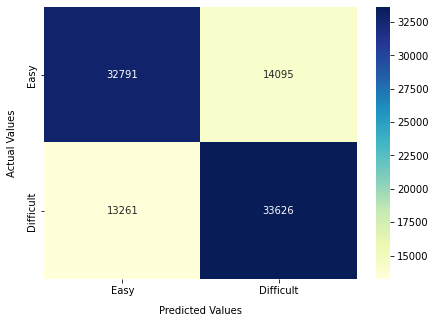

In [81]:
import seaborn as sns
import matplotlib as mpl

def plot_cf_matrix(y_true, y_pred):
  cf_matrix = metrics.confusion_matrix(y_true, y_pred).round(0)
  tick_lables = ('Easy', 'Difficult')

  fig = plt.figure(figsize=(7, 5))
  ax = plt.gca()
  ax = sns.heatmap(cf_matrix, 
              annot=True,
              fmt='.0f',
              xticklabels=tick_lables,
              yticklabels=tick_lables,
              cmap=mpl.cm.get_cmap('YlGnBu'),
              ax=ax,)
  
  ax.set_xlabel('Predicted Values', labelpad=10.0)
  ax.set_ylabel('Actual Values', labelpad=10.0)

plot_cf_matrix(y_val, val_y_hat)

Lets look at the most important features

In [55]:
# Get transformed feature names.
num_features_trf = (clf['preprocessor']
                    .transformers_[0][1]
                    ['binner']
                    .get_feature_names_out(num_features))

text_features_trf = (clf['preprocessor']
                 .transformers_[1][1]
                 ['tfidf']
                 .get_feature_names_out())

all_features_trf = list(num_features_trf) + list(text_features_trf)

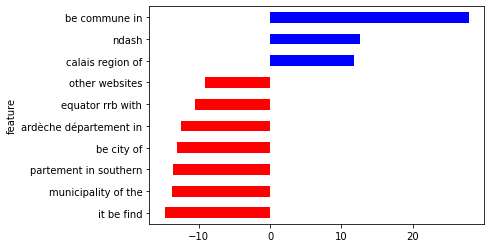

In [56]:
df_coef = pd.DataFrame({'feature':all_features_trf, 
                        'coef':clf['clf'].coef_[0],
                        'abscoef':np.abs(clf['clf'].coef_[0]),
                        'is_positive':clf['clf'].coef_[0] >= 0})
# What are top 10 most important features
def plot_top_10(df_plot):
  df_plot = (df_plot
    .sort_values('abscoef', ascending=False)
    .head(10)
    .sort_values('coef'))
  df_plot.plot.barh('feature', 'coef', 
                    color=df_plot.is_positive.map({True:'b', False:'r'}), 
                    legend=None)

plot_top_10(df_coef)

What are the most import readability features.

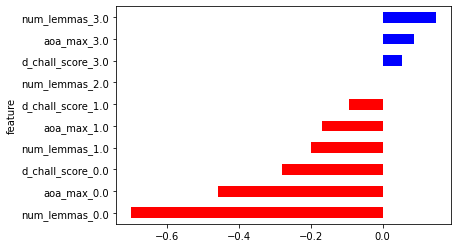

In [57]:
def plot_top_10_readability(df_plot):
  df_plot = (df_plot[df_plot.feature.isin(num_features_trf)]
    .sort_values('abscoef', ascending=False)
    .head(10)
    .sort_values('coef'))
  
  df_plot.plot.barh('feature', 'coef', 
                    color=df_plot.is_positive.map({True:'b', False:'r'}),
                    legend=None)
  
plot_top_10_readability(df_coef)

## Final test

In [58]:
clf = clf.fit(df_train, df_train['label'])

train_y_proba = clf.predict_proba(df_train)[:, 1]
train_y_hat = clf.predict(df_train)

test_y_proba = clf.predict_proba(df_test)[:, 1]
test_y_hat = clf.predict(df_test)

train_roc_auc = metrics.roc_auc_score(df_train['label'], train_y_proba)
train_accuracy = metrics.accuracy_score(df_train['label'], train_y_hat)
train_f1 = metrics.f1_score(df_train['label'], train_y_hat)
train_precision = metrics.precision_score(df_train['label'], train_y_hat)
train_recall = metrics.recall_score(df_train['label'], train_y_hat)

test_roc_auc = metrics.roc_auc_score(df_test['label'], test_y_proba)
test_accuracy = metrics.accuracy_score(df_test['label'], test_y_hat)
test_f1 = metrics.f1_score(df_test['label'], test_y_hat)
test_precision = metrics.precision_score(df_test['label'], test_y_hat)
test_recall = metrics.recall_score(df_test['label'], test_y_hat)

print()
print('Train ROC AUC:', train_roc_auc)
print('Train Accuracy Score:', train_accuracy)
print('Train F1 Score:', train_f1)
print('Train Precision Score:', train_precision)
print('Train Recall Score:', train_recall)
print()
print('Test ROC AUC:', test_roc_auc)
print('Test Accuracy Score:', test_accuracy)
print('Test F1 Score:', test_f1)
print('Test Precision Score:', test_precision)
print('Test Recall Score:', test_recall)


Train ROC AUC: 0.8095097603189146
Train Accuracy Score: 0.7318364561227646
Train F1 Score: 0.7345329399158621
Train Precision Score: 0.7272204686552812
Train Recall Score: 0.7419939641474624

Test ROC AUC: 0.7909177195445566
Test Accuracy Score: 0.7161195892120165
Test F1 Score: 0.7176978691927748
Test Precision Score: 0.7137297707749988
Test Recall Score: 0.7217103368845379


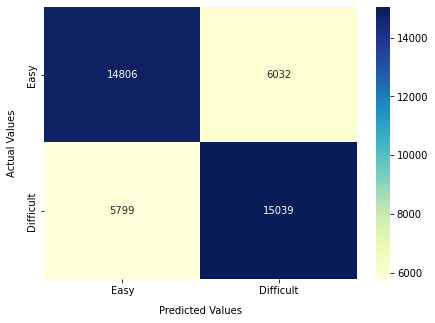

In [82]:
plot_cf_matrix(df_test['label'], test_y_hat)

Lets save our final model

In [60]:
model_path = ''.join([repo_path, 'logistic-regression-clf.joblib'])
joblib.dump(clf, model_path)

['/content/drive/MyDrive/milestone-ii/logistic-regression-clf.joblib']